# NYC Yellow Taxi Data - Pipeline de Preprocesamiento y Limpieza

Este notebook implementa el **pipeline de limpieza de datos** basado en los hallazgos del EDA y usando la clase `TaxiDataPreprocessor`.

## 🎯 Objetivos del Preprocesamiento:

### 📊 **Issues Críticos de Calidad Identificados en EDA:**
1. **28.01% registros** con discrepancias en total_amount (diferencia promedio: $2.50)
2. **Valores negativos generalizados**: 20,506 tarifas (0.57%), 20,709 totales (0.58%)
3. **VendorID inválido**: 14 registros con ID=5 (no documentado en diccionario TLC)
4. **Fechas incorrectas**: Rangos 2003-2022 (debería ser solo mayo 2022)
5. **73,587 viajes con 0 pasajeros** (2.05%)
6. **46,438 viajes con distancia 0** (1.29%)
7. **135 propinas anómalas** en pagos en efectivo

### ⏰ **Issues Temporales:**
- 3,030 viajes con duración negativa/cero (0.08%)
- 48,944 viajes < 1 minuto (1.36%)  
- 5,084 viajes > 3 horas (0.14%)

### 🎯 **Estrategia de Limpieza:**
- ✅ **Validar estructura básica** del dataset
- 🧹 **Limpiar campos temporales** (fechas inválidas, duraciones anómalas)
- 🏷️ **Limpiar campos categóricos** (valores inválidos según diccionario TLC)
- 💰 **Limpiar campos monetarios** (valores negativos, discrepancias)
- 🧮 **Validar y corregir total_amount**
- 🎯 **Remover outliers extremos**

> **Nota**: La ingeniería de características se realiza en un módulo separado (`features.py`)

## 1. Configuración e Importación de Librerías

In [12]:
# Importar librerías necesarias
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Agregar src al path para imports
project_root = Path().cwd().parent
src_path = project_root / 'src'
sys.path.append(str(src_path))

print(f"📁 Directorio del proyecto: {project_root}")
print(f"🐍 Versión de Python: {sys.version}")
print(f"📊 Versión de Pandas: {pd.__version__}")
print(f"🔢 Versión de NumPy: {np.__version__}")

📁 Directorio del proyecto: d:\VSCode\nyc_taxi_project
🐍 Versión de Python: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
📊 Versión de Pandas: 2.3.3
🔢 Versión de NumPy: 2.3.5


## 2. Importación del Preprocesador y Configuración

In [13]:
# Importar el preprocesador y configuración
from data.preprocess import TaxiDataPreprocessor
from config.paths import RAW_DATA, PROCESSED_DATA
from config.settings import PREPROCESSING_PARAMS

# Verificar rutas de archivos
print("📂 CONFIGURACIÓN DE RUTAS:")
print(f"   Datos raw: {RAW_DATA}")
print(f"   Datos procesados: {PROCESSED_DATA}")
print(f"   Existe archivo raw: {Path(RAW_DATA).exists()}")

print(f"\n⚙️ PARÁMETROS DE PREPROCESAMIENTO:")
for key, value in PREPROCESSING_PARAMS.items():
    print(f"   {key}: {value}")

# Inicializar preprocesador
preprocessor = TaxiDataPreprocessor()
print(f"\n✅ TaxiDataPreprocessor inicializado correctamente")

2025-11-28 18:16:25,958 - nyc_taxi_logger - INFO - TaxiDataPreprocessor inicializado


📂 CONFIGURACIÓN DE RUTAS:
   Datos raw: d:\VSCode\nyc_taxi_project\data\raw\yellow_tripdata_2022-05.parquet
   Datos procesados: d:\VSCode\nyc_taxi_project\data\processed\processed_data.parquet
   Existe archivo raw: True

⚙️ PARÁMETROS DE PREPROCESAMIENTO:
   target_year: 2022
   target_month: 5
   min_trip_duration_minutes: 1
   max_trip_duration_minutes: 180
   min_passengers: 1
   max_passengers: 6
   min_fare_amount: 0.01
   min_trip_distance: 0.01
   outlier_method: iqr
   outlier_factor: 1.5
   remove_extreme_outliers: True
   valid_vendor_ids: [1, 2, 6, 7]
   valid_ratecode_ids: [1, 2, 3, 4, 5, 6, 99]
   valid_payment_types: [0, 1, 2, 3, 4, 5, 6]
   valid_store_flags: ['Y', 'N']
   max_fare_amount_percentile: 0.99
   max_total_amount_percentile: 0.99
   max_trip_distance_percentile: 0.99
   create_temporal_features: True
   create_ratio_features: True
   create_categorical_indicators: True
   create_distance_categories: True
   data_year: 2022
   data_month: 5

✅ TaxiDataPrepro

## 3. Carga y Validación Inicial de Datos

In [14]:
# Cargar datos raw
print("📥 CARGANDO DATOS RAW...")
print("="*50)

data = preprocessor.load_data()

print(f"\n📊 INFORMACIÓN BÁSICA DEL DATASET:")
print(f"   Forma: {data.shape}")
print(f"   Tamaño en memoria: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   Tipo de datos por columna:")

# Mostrar tipos de datos
for col, dtype in data.dtypes.items():
    print(f"     {col:<25}: {dtype}")

print(f"\n🔍 PRIMEROS 5 REGISTROS:")
display(data.head())

2025-11-28 18:16:25,981 - nyc_taxi_logger - INFO - Cargando datos desde: d:\VSCode\nyc_taxi_project\data\raw\yellow_tripdata_2022-05.parquet


📥 CARGANDO DATOS RAW...


2025-11-28 18:16:27,202 - nyc_taxi_logger - INFO - Datos cargados: 3,588,295 filas, 19 columnas



📊 INFORMACIÓN BÁSICA DEL DATASET:
   Forma: (3588295, 19)
   Tamaño en memoria: 687.06 MB
   Tipo de datos por columna:
     VendorID                 : int64
     tpep_pickup_datetime     : datetime64[us]
     tpep_dropoff_datetime    : datetime64[us]
     passenger_count          : float64
     trip_distance            : float64
     RatecodeID               : float64
     store_and_fwd_flag       : object
     PULocationID             : int64
     DOLocationID             : int64
     payment_type             : int64
     fare_amount              : float64
     extra                    : float64
     mta_tax                  : float64
     tip_amount               : float64
     tolls_amount             : float64
     improvement_surcharge    : float64
     total_amount             : float64
     congestion_surcharge     : float64
     airport_fee              : float64

🔍 PRIMEROS 5 REGISTROS:
   Tamaño en memoria: 687.06 MB
   Tipo de datos por columna:
     VendorID              

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,4.1,1.0,N,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,2.3,1.0,N,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,4.2,1.0,N,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0
3,1,2022-05-01 00:48:18,2022-05-01 01:28:02,1.0,0.0,1.0,N,79,182,1,41.2,0.0,0.5,0.00,0.0,0.3,42.00,0.0,0.0
4,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,1.6,1.0,N,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0


## 4. Validación de Estructura Básica

2025-11-28 18:16:30,917 - nyc_taxi_logger - INFO - === VALIDACIÓN DE ESTRUCTURA BÁSICA ===


🔍 VALIDACIÓN DE ESTRUCTURA BÁSICA


2025-11-28 18:16:37,889 - nyc_taxi_logger - INFO - Columnas faltantes: set()
2025-11-28 18:16:37,891 - nyc_taxi_logger - INFO - Columnas adicionales: set()
2025-11-28 18:16:37,893 - nyc_taxi_logger - INFO - Registros con valores faltantes: 647620
2025-11-28 18:16:37,895 - nyc_taxi_logger - INFO - Registros duplicados: 0
2025-11-28 18:16:37,891 - nyc_taxi_logger - INFO - Columnas adicionales: set()
2025-11-28 18:16:37,893 - nyc_taxi_logger - INFO - Registros con valores faltantes: 647620
2025-11-28 18:16:37,895 - nyc_taxi_logger - INFO - Registros duplicados: 0



📊 RESULTADOS DE LA VALIDACIÓN:
   Total de registros: 3,588,295
   Total de columnas: 19
   Memoria utilizada: 687.06 MB

📋 COLUMNAS FALTANTES:
   ✅ Todas las columnas esperadas están presentes

📋 COLUMNAS ADICIONALES:
   ✅ No hay columnas adicionales inesperadas

🔢 VALORES FALTANTES POR COLUMNA:


,Columna,Valores_Faltantes,Porcentaje
0,passenger_count,129524,3.61%
1,RatecodeID,129524,3.61%
2,store_and_fwd_flag,129524,3.61%
3,congestion_surcharge,129524,3.61%
4,airport_fee,129524,3.61%



🔄 REGISTROS DUPLICADOS:
   Duplicados encontrados: 0 (0.00%)


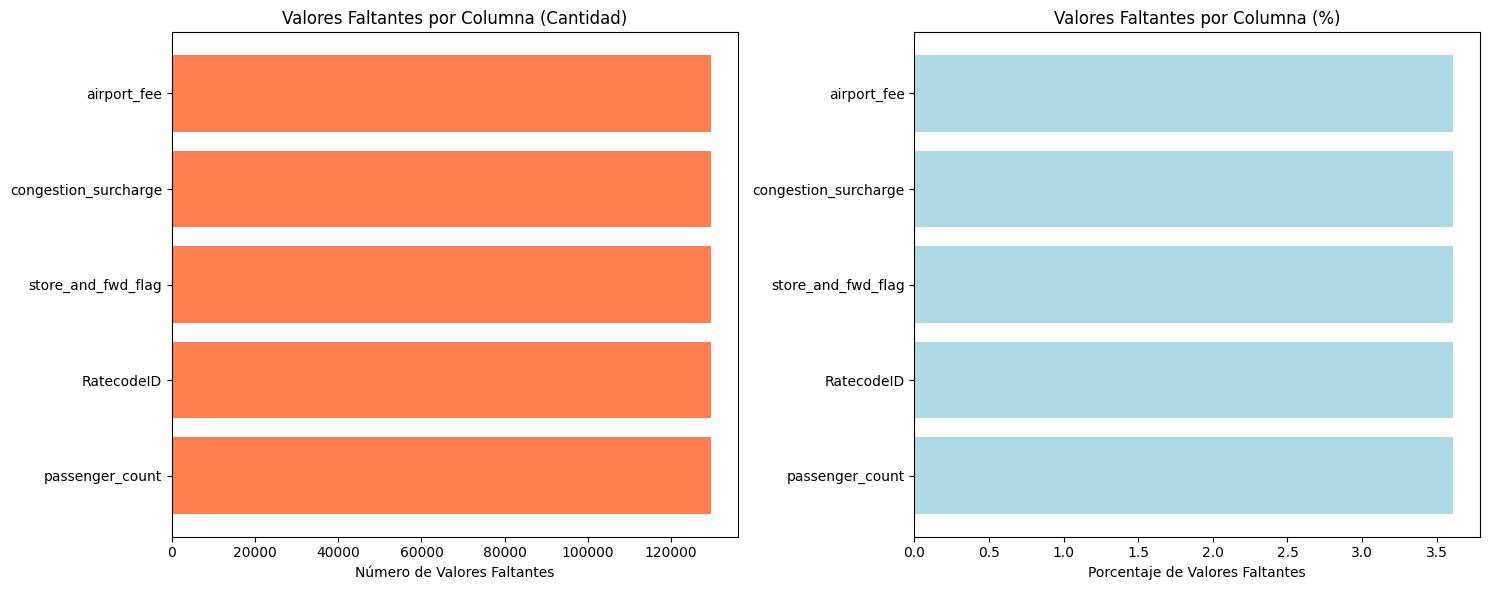

In [15]:
# Ejecutar validación de estructura básica
print("🔍 VALIDACIÓN DE ESTRUCTURA BÁSICA")
print("="*50)

validation_stats = preprocessor.validate_basic_structure()

print(f"\n📊 RESULTADOS DE LA VALIDACIÓN:")
print(f"   Total de registros: {validation_stats['total_records']:,}")
print(f"   Total de columnas: {validation_stats['total_columns']}")
print(f"   Memoria utilizada: {validation_stats['memory_usage_mb']:.2f} MB")

print(f"\n📋 COLUMNAS FALTANTES:")
if validation_stats['missing_columns']:
    for col in validation_stats['missing_columns']:
        print(f"   ❌ {col}")
else:
    print("   ✅ Todas las columnas esperadas están presentes")

print(f"\n📋 COLUMNAS ADICIONALES:")
if validation_stats['extra_columns']:
    for col in validation_stats['extra_columns']:
        print(f"   ➕ {col}")
else:
    print("   ✅ No hay columnas adicionales inesperadas")

print(f"\n🔢 VALORES FALTANTES POR COLUMNA:")
if validation_stats['missing_values']:
    missing_df = pd.DataFrame([
        {
            'Columna': col, 
            'Valores_Faltantes': info['count'], 
            'Porcentaje': f"{info['percentage']:.2f}%"
        }
        for col, info in validation_stats['missing_values'].items()
    ]).sort_values('Valores_Faltantes', ascending=False)
    
    display(missing_df)
else:
    print("   ✅ No hay valores faltantes en el dataset")

print(f"\n🔄 REGISTROS DUPLICADOS:")
dup_info = validation_stats['duplicates']
print(f"   Duplicados encontrados: {dup_info['count']:,} ({dup_info['percentage']:.2f}%)")

# Visualización de valores faltantes
if validation_stats['missing_values']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico de barras de valores faltantes
    missing_counts = [info['count'] for info in validation_stats['missing_values'].values()]
    missing_cols = list(validation_stats['missing_values'].keys())
    
    ax1.barh(missing_cols, missing_counts, color='coral')
    ax1.set_title('Valores Faltantes por Columna (Cantidad)')
    ax1.set_xlabel('Número de Valores Faltantes')
    
    # Gráfico de porcentajes
    missing_pcts = [info['percentage'] for info in validation_stats['missing_values'].values()]
    
    ax2.barh(missing_cols, missing_pcts, color='lightblue')
    ax2.set_title('Valores Faltantes por Columna (%)')
    ax2.set_xlabel('Porcentaje de Valores Faltantes')
    
    plt.tight_layout()
    plt.show()
else:
    print("📊 No hay valores faltantes para visualizar")

## 5. Limpieza de Campos Temporales

2025-11-28 18:16:38,261 - nyc_taxi_logger - INFO - === LIMPIEZA DE CAMPOS TEMPORALES ===


🕒 LIMPIEZA DE CAMPOS TEMPORALES

📊 Registros antes de limpieza temporal: 3,588,295


2025-11-28 18:16:38,582 - nyc_taxi_logger - INFO - Registros con fechas fuera 2022-5: 143 (0.00%)
2025-11-28 18:16:39,188 - nyc_taxi_logger - INFO - Filtrados 143 registros con fechas inválidas
2025-11-28 18:16:39,188 - nyc_taxi_logger - INFO - Filtrados 143 registros con fechas inválidas
2025-11-28 18:16:39,311 - nyc_taxi_logger - INFO - Registros con duración inválida: 54,011 (1.51%)
2025-11-28 18:16:39,311 - nyc_taxi_logger - INFO - Registros con duración inválida: 54,011 (1.51%)
2025-11-28 18:16:40,355 - nyc_taxi_logger - INFO - Filtrados 54,011 registros con duración inválida
2025-11-28 18:16:40,357 - nyc_taxi_logger - INFO - Registros removidos por fechas/duración: 54,154
2025-11-28 18:16:40,358 - nyc_taxi_logger - INFO - Registros restantes: 3,534,141
2025-11-28 18:16:40,355 - nyc_taxi_logger - INFO - Filtrados 54,011 registros con duración inválida
2025-11-28 18:16:40,357 - nyc_taxi_logger - INFO - Registros removidos por fechas/duración: 54,154
2025-11-28 18:16:40,358 - nyc_ta


🧹 RESULTADOS DE LIMPIEZA TEMPORAL:
   Registros procesados: 3,588,295
   Registros finales: 3,534,141
   Registros removidos: 54,154
   Porcentaje removido: 1.51%

🔍 CALIDAD DE DATOS TEMPORALES POST-LIMPIEZA:
   Rango de fechas de recogida: 2022-05-01 00:00:00 a 2022-05-31 23:59:59
   Rango de fechas de entrega: 2022-05-01 00:01:58 a 2022-06-01 01:03:01

   Estadísticas de duración (minutos):
   Min: 1.00, Max: 179.90
   Media: 16.64, Mediana: 12.85
   Media: 16.64, Mediana: 12.85


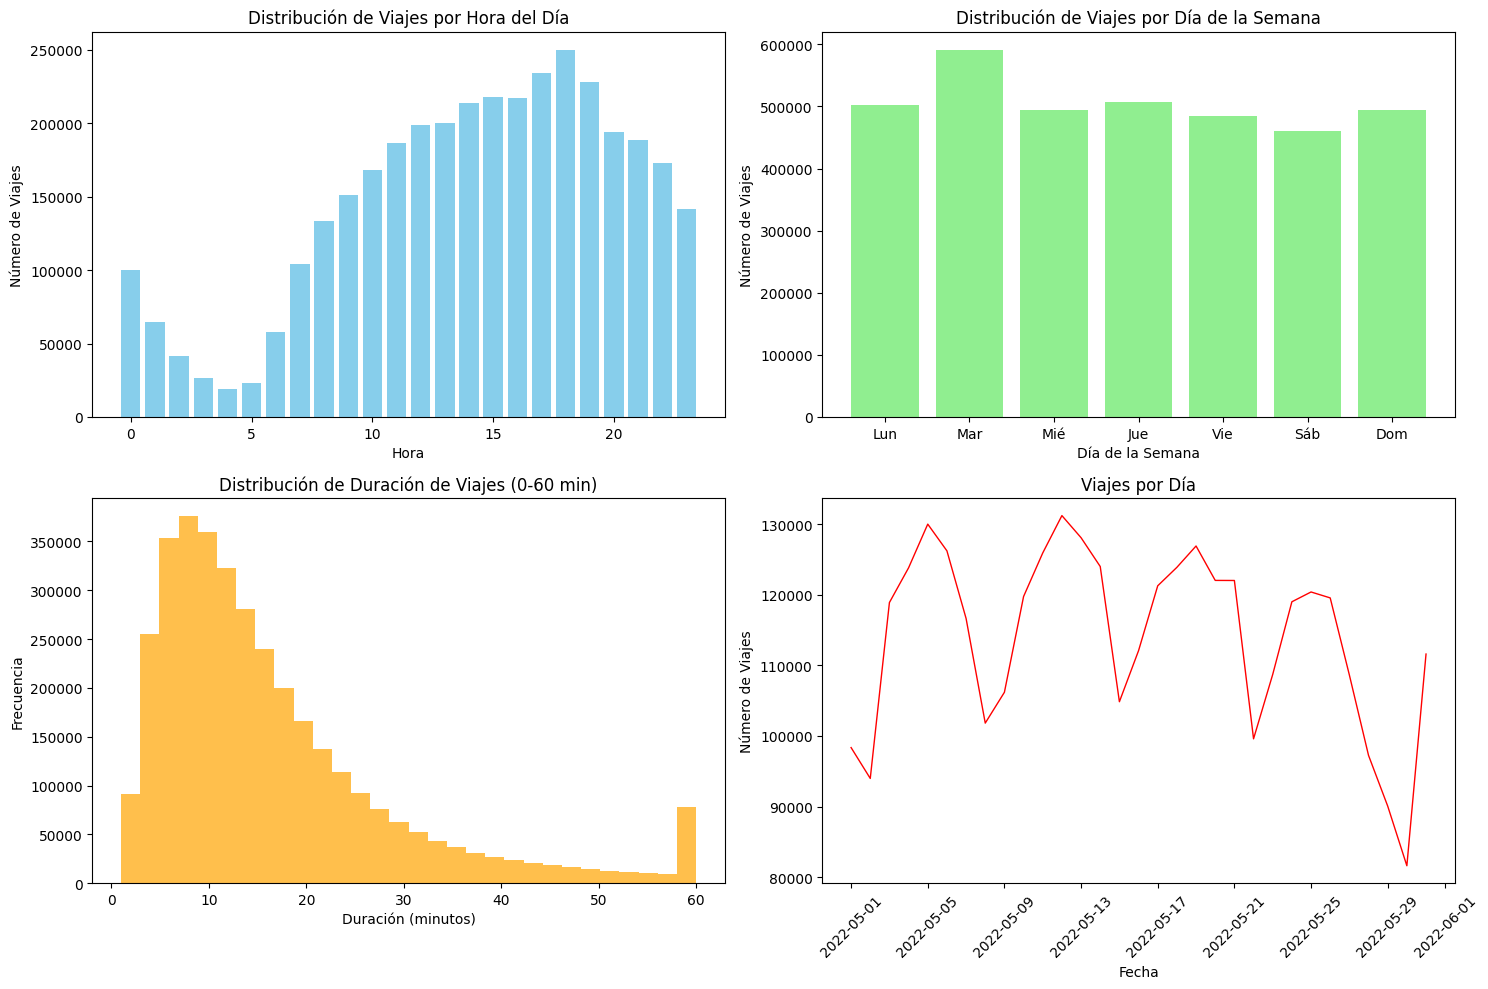

In [16]:
# Ejecutar limpieza de datos temporales
print("🕒 LIMPIEZA DE CAMPOS TEMPORALES")
print("="*50)

# Obtener estadísticas antes de la limpieza
initial_count = len(preprocessor.df)
print(f"\n📊 Registros antes de limpieza temporal: {initial_count:,}")

# Ejecutar limpieza temporal
cleaned_temporal = preprocessor.clean_datetime_fields()
temporal_stats = preprocessor.preprocessing_stats['datetime_cleaning']

print(f"\n🧹 RESULTADOS DE LIMPIEZA TEMPORAL:")
print(f"   Registros procesados: {temporal_stats['initial_count']:,}")
print(f"   Registros finales: {temporal_stats['final_count']:,}")
print(f"   Registros removidos: {temporal_stats['removed_records']:,}")
print(f"   Porcentaje removido: {temporal_stats['removal_percentage']:.2f}%")

# Verificar la calidad de los datos temporales después de la limpieza
if len(preprocessor.df) > 0:
    print(f"\n🔍 CALIDAD DE DATOS TEMPORALES POST-LIMPIEZA:")
    
    # Verificar rango de fechas
    min_pickup = preprocessor.df['tpep_pickup_datetime'].min()
    max_pickup = preprocessor.df['tpep_pickup_datetime'].max()
    min_dropoff = preprocessor.df['tpep_dropoff_datetime'].min()
    max_dropoff = preprocessor.df['tpep_dropoff_datetime'].max()
    
    print(f"   Rango de fechas de recogida: {min_pickup} a {max_pickup}")
    print(f"   Rango de fechas de entrega: {min_dropoff} a {max_dropoff}")
    
    # Verificar duraciones si existe la columna
    if 'trip_duration_minutes' in preprocessor.df.columns:
        durations = preprocessor.df['trip_duration_minutes']
        
        print(f"\n   Estadísticas de duración (minutos):")
        print(f"   Min: {durations.min():.2f}, Max: {durations.max():.2f}")
        print(f"   Media: {durations.mean():.2f}, Mediana: {durations.median():.2f}")
        
        # Visualización de distribución temporal
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Distribución por hora del día
        pickup_hour = preprocessor.df['tpep_pickup_datetime'].dt.hour
        hourly_counts = pickup_hour.value_counts().sort_index()
        
        axes[0,0].bar(hourly_counts.index, hourly_counts.values, color='skyblue')
        axes[0,0].set_title('Distribución de Viajes por Hora del Día')
        axes[0,0].set_xlabel('Hora')
        axes[0,0].set_ylabel('Número de Viajes')
        
        # Distribución por día de la semana
        pickup_weekday = preprocessor.df['tpep_pickup_datetime'].dt.dayofweek
        weekday_counts = pickup_weekday.value_counts().sort_index()
        weekday_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
        
        axes[0,1].bar(range(7), [weekday_counts.get(i, 0) for i in range(7)], color='lightgreen')
        axes[0,1].set_title('Distribución de Viajes por Día de la Semana')
        axes[0,1].set_xlabel('Día de la Semana')
        axes[0,1].set_ylabel('Número de Viajes')
        axes[0,1].set_xticks(range(7))
        axes[0,1].set_xticklabels(weekday_names)
        
        # Distribución de duraciones (histograma)
        axes[1,0].hist(durations.clip(0, 60), bins=30, color='orange', alpha=0.7)
        axes[1,0].set_title('Distribución de Duración de Viajes (0-60 min)')
        axes[1,0].set_xlabel('Duración (minutos)')
        axes[1,0].set_ylabel('Frecuencia')
        
        # Serie temporal de viajes por día
        daily_trips = preprocessor.df.groupby(preprocessor.df['tpep_pickup_datetime'].dt.date).size()
        axes[1,1].plot(daily_trips.index, daily_trips.values, color='red', linewidth=1)
        axes[1,1].set_title('Viajes por Día')
        axes[1,1].set_xlabel('Fecha')
        axes[1,1].set_ylabel('Número de Viajes')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ No quedan datos después de la limpieza temporal!")

## 6. Limpieza de Campos Categóricos

2025-11-28 18:16:43,204 - nyc_taxi_logger - INFO - === LIMPIEZA DE CAMPOS CATEGÓRICOS ===
2025-11-28 18:16:43,276 - nyc_taxi_logger - INFO - VendorIDs inválidos: 14
2025-11-28 18:16:43,276 - nyc_taxi_logger - INFO - VendorIDs inválidos: 14


🏷️ LIMPIEZA DE CAMPOS CATEGÓRICOS

📊 Registros antes de limpieza categórica: 3,534,141


2025-11-28 18:16:44,038 - nyc_taxi_logger - INFO - Registros con passenger_count inválido: 198,167
2025-11-28 18:16:46,310 - nyc_taxi_logger - INFO - Registros removidos por campos categóricos: 198,181
2025-11-28 18:16:46,310 - nyc_taxi_logger - INFO - Registros removidos por campos categóricos: 198,181



🧹 RESULTADOS DE LIMPIEZA CATEGÓRICA:
   Registros procesados: 3,534,141
   Registros finales: 3,335,960
   Registros removidos: 198,181
   Porcentaje removido: 5.61%

🔍 DISTRIBUCIÓN DE CAMPOS CATEGÓRICOS POST-LIMPIEZA:


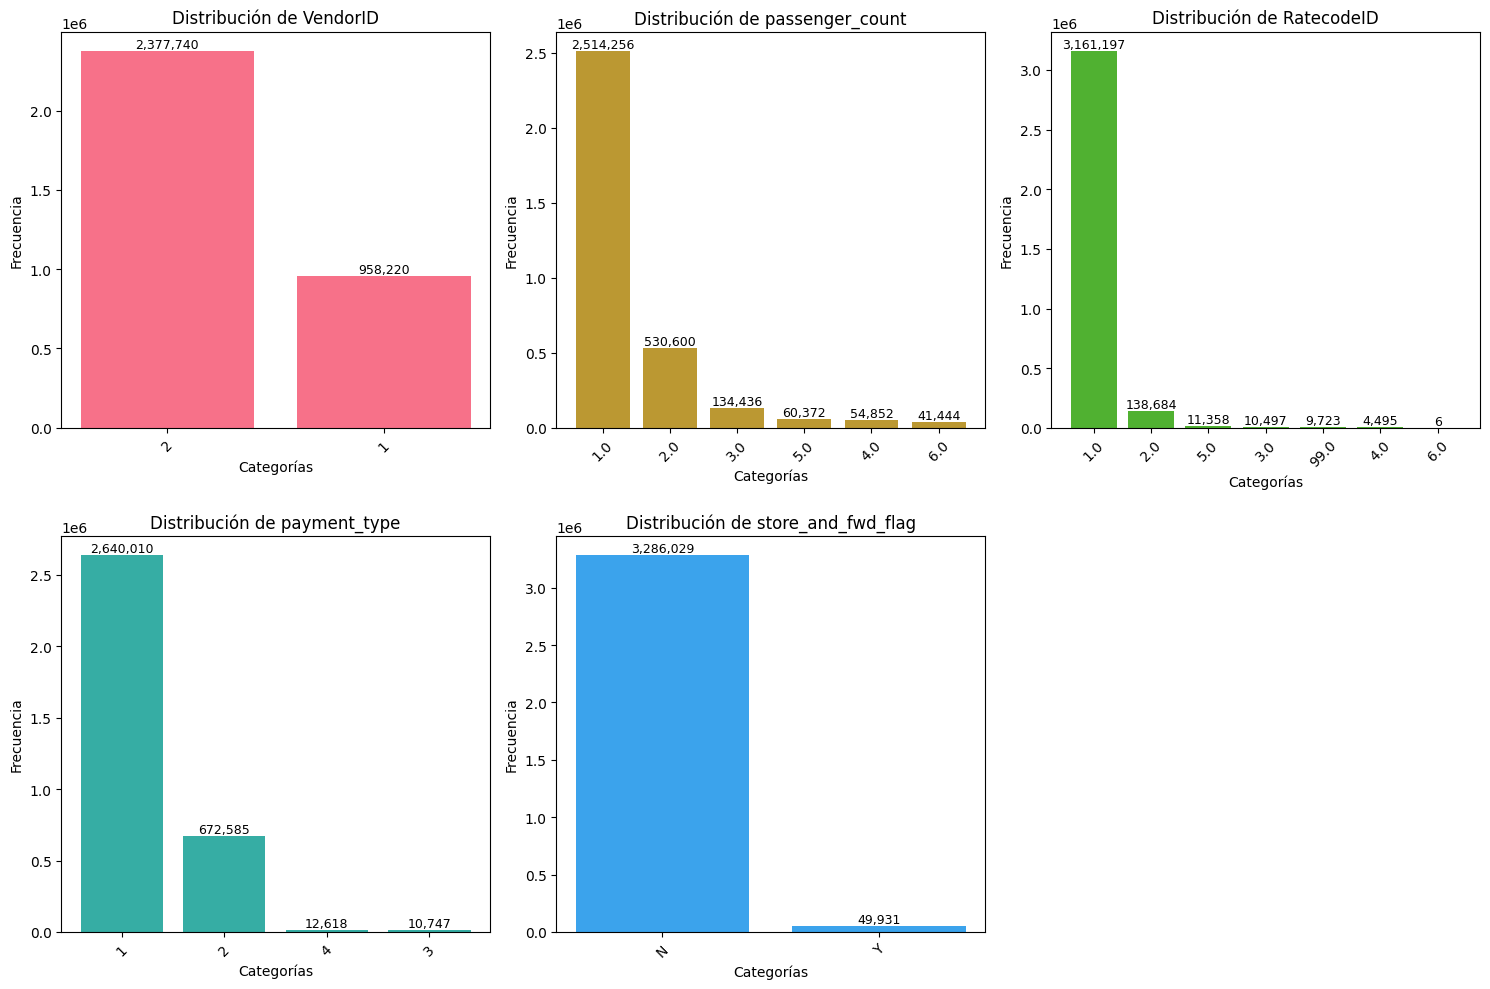


   📊 VendorID:
      2: 2,377,740 (71.28%)
      1: 958,220 (28.72%)

   📊 passenger_count:
      1.0: 2,514,256 (75.37%)
      2.0: 530,600 (15.91%)
      3.0: 134,436 (4.03%)
      5.0: 60,372 (1.81%)
      4.0: 54,852 (1.64%)
      6.0: 41,444 (1.24%)

   📊 RatecodeID:
      1.0: 3,161,197 (94.76%)
      2.0: 138,684 (4.16%)
      5.0: 11,358 (0.34%)
      3.0: 10,497 (0.31%)
      99.0: 9,723 (0.29%)
      4.0: 4,495 (0.13%)
      6.0: 6 (0.00%)

   📊 payment_type:
      1: 2,640,010 (79.14%)
      2: 672,585 (20.16%)
      4: 12,618 (0.38%)
      3: 10,747 (0.32%)

   📊 store_and_fwd_flag:
      N: 3,286,029 (98.50%)
      Y: 49,931 (1.50%)


In [17]:
# Ejecutar limpieza de campos categóricos
print("🏷️ LIMPIEZA DE CAMPOS CATEGÓRICOS")
print("="*50)

# Obtener estadísticas antes de la limpieza
initial_count = len(preprocessor.df)
print(f"\n📊 Registros antes de limpieza categórica: {initial_count:,}")

# Ejecutar limpieza categórica
cleaned_categorical = preprocessor.clean_categorical_fields()
categorical_stats = preprocessor.preprocessing_stats['categorical_cleaning']

print(f"\n🧹 RESULTADOS DE LIMPIEZA CATEGÓRICA:")
print(f"   Registros procesados: {categorical_stats['initial_count']:,}")
print(f"   Registros finales: {categorical_stats['final_count']:,}")
print(f"   Registros removidos: {categorical_stats['removed_records']:,}")
print(f"   Porcentaje removido: {categorical_stats['removal_percentage']:.2f}%")

# Verificar la distribución de campos categóricos después de la limpieza
if len(preprocessor.df) > 0:
    print(f"\n🔍 DISTRIBUCIÓN DE CAMPOS CATEGÓRICOS POST-LIMPIEZA:")
    
    # Visualizar distribuciones categóricas
    categorical_fields = ['VendorID', 'passenger_count', 'RatecodeID', 'payment_type', 'store_and_fwd_flag']
    existing_fields = [field for field in categorical_fields if field in preprocessor.df.columns]
    
    if existing_fields:
        n_fields = len(existing_fields)
        n_cols = min(3, n_fields)
        n_rows = (n_fields + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        if n_fields == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.flatten() if n_cols > 1 else [axes]
        else:
            axes = axes.flatten()
        
        for i, field in enumerate(existing_fields):
            if i < len(axes):
                value_counts = preprocessor.df[field].value_counts()
                
                # Crear gráfico de barras
                axes[i].bar(range(len(value_counts)), value_counts.values, color=f'C{i}')
                axes[i].set_title(f'Distribución de {field}')
                axes[i].set_xlabel('Categorías')
                axes[i].set_ylabel('Frecuencia')
                axes[i].set_xticks(range(len(value_counts)))
                axes[i].set_xticklabels([str(x) for x in value_counts.index], rotation=45)
                
                # Mostrar valores sobre las barras
                for j, v in enumerate(value_counts.values):
                    axes[i].text(j, v, f'{v:,}', ha='center', va='bottom', fontsize=9)
        
        # Ocultar subplots no utilizados
        for i in range(len(existing_fields), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # Mostrar estadísticas detalladas
    for field in existing_fields:
        print(f"\n   📊 {field}:")
        value_counts = preprocessor.df[field].value_counts()
        for value, count in value_counts.head(10).items():
            percentage = (count / len(preprocessor.df)) * 100
            print(f"      {value}: {count:,} ({percentage:.2f}%)")
        
        if len(value_counts) > 10:
            print(f"      ... y {len(value_counts) - 10} valores más")
else:
    print("⚠️ No quedan datos después de la limpieza categórica!")

## 7. Limpieza de Campos Monetarios

2025-11-28 18:16:48,538 - nyc_taxi_logger - INFO - === LIMPIEZA DE CAMPOS MONETARIOS ===
2025-11-28 18:16:48,557 - nyc_taxi_logger - INFO - Valores negativos en fare_amount: 15,405
2025-11-28 18:16:48,557 - nyc_taxi_logger - INFO - Valores negativos en fare_amount: 15,405


💰 LIMPIEZA DE CAMPOS MONETARIOS

📊 Registros antes de limpieza monetaria: 3,335,960


2025-11-28 18:16:49,294 - nyc_taxi_logger - INFO - Valores negativos en total_amount: 118
2025-11-28 18:16:50,057 - nyc_taxi_logger - INFO - Viajes con fare_amount = 0: 460
2025-11-28 18:16:50,057 - nyc_taxi_logger - INFO - Viajes con fare_amount = 0: 460
2025-11-28 18:16:50,994 - nyc_taxi_logger - INFO - Viajes con distancia 0: 14,032
2025-11-28 18:16:50,994 - nyc_taxi_logger - INFO - Viajes con distancia 0: 14,032
2025-11-28 18:16:51,731 - nyc_taxi_logger - INFO - Propinas anómalas en efectivo: 60
2025-11-28 18:16:51,731 - nyc_taxi_logger - INFO - Propinas anómalas en efectivo: 60
2025-11-28 18:16:51,822 - nyc_taxi_logger - INFO - Tarifas extremadamente altas removidas: 1,009
2025-11-28 18:16:51,822 - nyc_taxi_logger - INFO - Tarifas extremadamente altas removidas: 1,009
2025-11-28 18:16:52,522 - nyc_taxi_logger - INFO - Registros removidos por campos monetarios: 31,024
2025-11-28 18:16:52,522 - nyc_taxi_logger - INFO - Registros removidos por campos monetarios: 31,024



🧹 RESULTADOS DE LIMPIEZA MONETARIA:
   Registros procesados: 3,335,960
   Registros finales: 3,304,936
   Registros removidos: 31,024
   Porcentaje removido: 0.93%

🔍 ESTADÍSTICAS DE CAMPOS MONETARIOS POST-LIMPIEZA:


,fare_amount,tip_amount,total_amount,trip_distance
count,3304936.00,3304936.00,3304936.00,3304936.00
mean,14.79,2.78,21.73,3.66
std,12.81,3.16,16.54,17.39
min,0.01,0.00,0.31,0.01
25%,7.00,1.00,12.35,1.18
50%,10.50,2.16,15.96,1.95
75%,16.50,3.45,23.15,3.68
max,156.00,408.00,845.55,29445.65


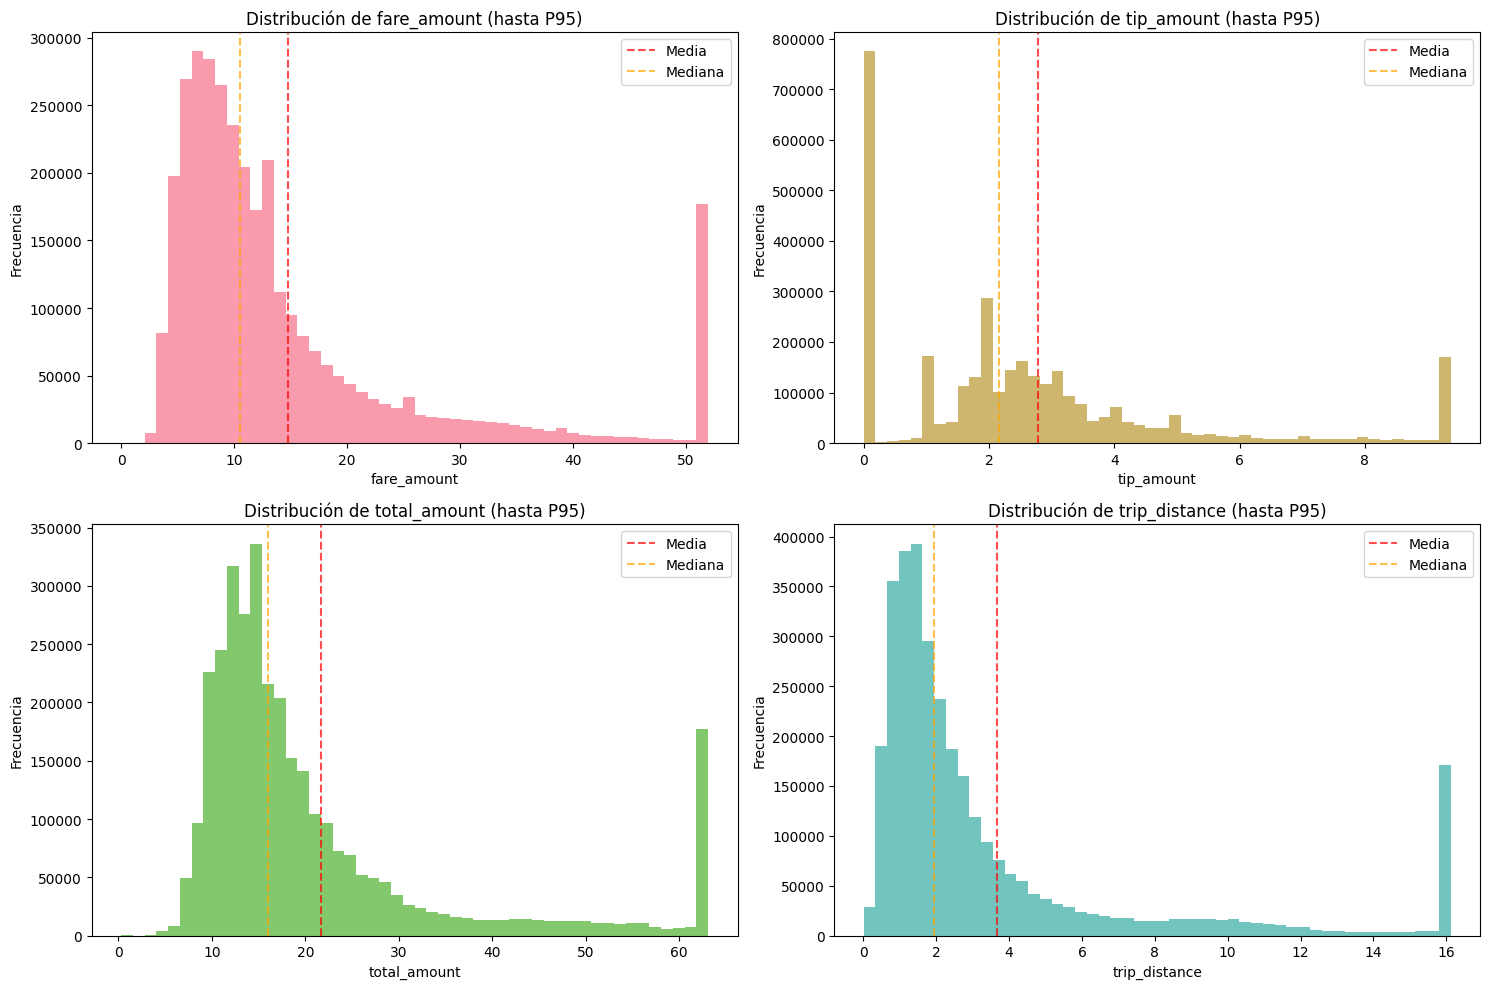


📊 VALORES EXTREMOS RESTANTES:
   fare_amount: 33,027 valores > P99 ($53.50)
   tip_amount: 33,028 valores > P99 ($14.14)
   total_amount: 31,656 valores > P99 ($79.62)
   trip_distance: 32,963 valores > P99 ($20.28)
   trip_distance: 32,963 valores > P99 ($20.28)


In [18]:
# Ejecutar limpieza de campos monetarios
print("💰 LIMPIEZA DE CAMPOS MONETARIOS")
print("="*50)

# Obtener estadísticas antes de la limpieza
initial_count = len(preprocessor.df)
print(f"\n📊 Registros antes de limpieza monetaria: {initial_count:,}")

# Ejecutar limpieza monetaria
cleaned_monetary = preprocessor.clean_monetary_fields()
monetary_stats = preprocessor.preprocessing_stats['monetary_cleaning']

print(f"\n🧹 RESULTADOS DE LIMPIEZA MONETARIA:")
print(f"   Registros procesados: {monetary_stats['initial_count']:,}")
print(f"   Registros finales: {monetary_stats['final_count']:,}")
print(f"   Registros removidos: {monetary_stats['removed_records']:,}")
print(f"   Porcentaje removido: {monetary_stats['removal_percentage']:.2f}%")

# Verificar la distribución de campos monetarios después de la limpieza
if len(preprocessor.df) > 0:
    print(f"\n🔍 ESTADÍSTICAS DE CAMPOS MONETARIOS POST-LIMPIEZA:")
    
    monetary_fields = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']
    existing_fields = [field for field in monetary_fields if field in preprocessor.df.columns]
    
    if existing_fields:
        # Mostrar estadísticas descriptivas
        stats_df = preprocessor.df[existing_fields].describe()
        display(stats_df.round(2))
        
        # Visualización de distribuciones
        n_fields = len(existing_fields)
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, field in enumerate(existing_fields[:4]):
            if i < len(axes):
                # Histograma con límite en percentil 95 para evitar outliers extremos
                p95 = preprocessor.df[field].quantile(0.95)
                data_clipped = preprocessor.df[field].clip(upper=p95)
                
                axes[i].hist(data_clipped, bins=50, alpha=0.7, color=f'C{i}')
                axes[i].set_title(f'Distribución de {field} (hasta P95)')
                axes[i].set_xlabel(field)
                axes[i].set_ylabel('Frecuencia')
                axes[i].axvline(preprocessor.df[field].mean(), color='red', linestyle='--', alpha=0.7, label='Media')
                axes[i].axvline(preprocessor.df[field].median(), color='orange', linestyle='--', alpha=0.7, label='Mediana')
                axes[i].legend()
        
        # Ocultar subplots no utilizados
        for i in range(len(existing_fields), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Verificar valores extremos restantes
        print(f"\n📊 VALORES EXTREMOS RESTANTES:")
        for field in existing_fields:
            p99 = preprocessor.df[field].quantile(0.99)
            extreme_values = (preprocessor.df[field] > p99).sum()
            print(f"   {field}: {extreme_values:,} valores > P99 (${p99:.2f})")
else:
    print("⚠️ No quedan datos después de la limpieza monetaria!")

## 8. Validación de total_amount

2025-11-28 18:16:56,565 - nyc_taxi_logger - INFO - === VALIDACIÓN DE total_amount ===


🧮 VALIDACIÓN DE total_amount


2025-11-28 18:16:56,939 - nyc_taxi_logger - INFO - Registros con discrepancias en total_amount: 927,828 (28.07%)
2025-11-28 18:16:56,976 - nyc_taxi_logger - INFO - Diferencia promedio: $2.51
2025-11-28 18:16:56,989 - nyc_taxi_logger - INFO - Diferencia máxima: $14.16
2025-11-28 18:16:56,976 - nyc_taxi_logger - INFO - Diferencia promedio: $2.51
2025-11-28 18:16:56,989 - nyc_taxi_logger - INFO - Diferencia máxima: $14.16
2025-11-28 18:16:57,075 - nyc_taxi_logger - INFO - total_amount corregido basado en suma de componentes
2025-11-28 18:16:57,075 - nyc_taxi_logger - INFO - total_amount corregido basado en suma de componentes



🔍 RESULTADOS DE VALIDACIÓN DE total_amount:
   Discrepancias encontradas: 927,828
   Porcentaje de discrepancias: 28.07%
   Diferencia promedio: $2.51
   Diferencia máxima: $14.16
   ✅ total_amount corregido basado en suma de componentes

🔍 VERIFICACIÓN POST-CORRECCIÓN:
   Registros con diferencias > $0.01: 0
   Diferencia máxima restante: $0.00
   ✅ total_amount está consistente con sus componentes
   Registros con diferencias > $0.01: 0
   Diferencia máxima restante: $0.00
   ✅ total_amount está consistente con sus componentes


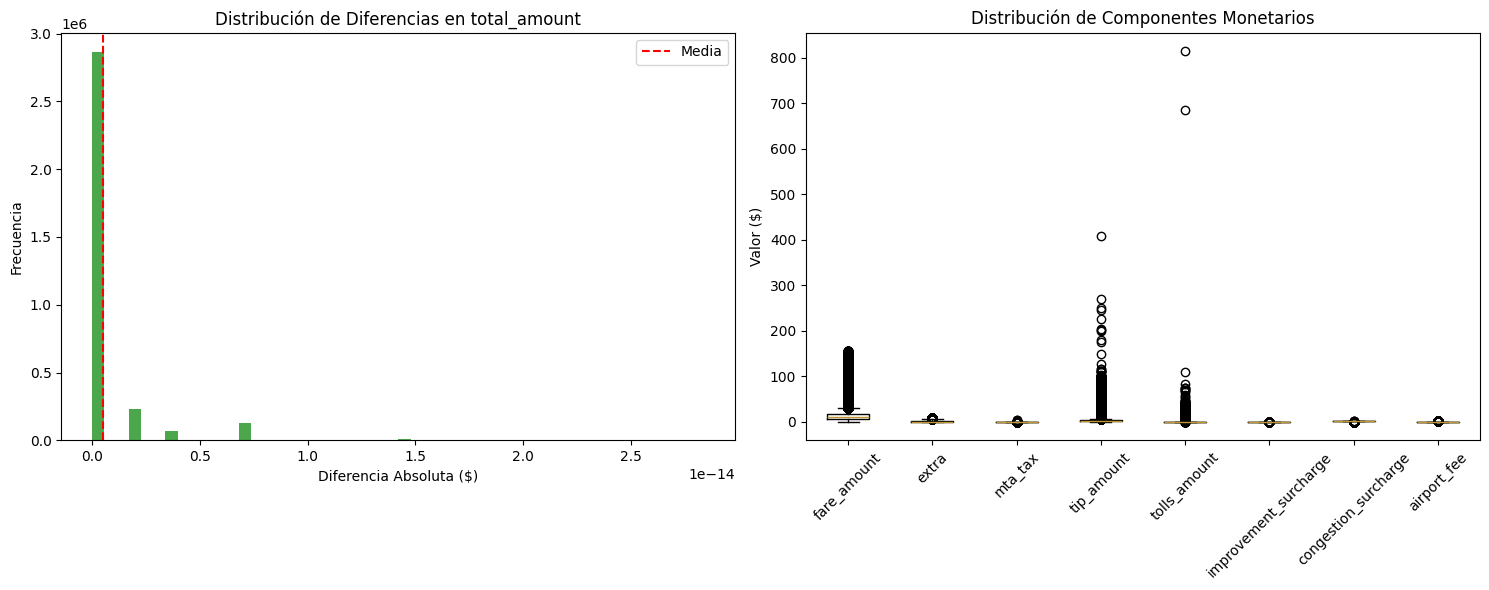

In [19]:
# Ejecutar validación de total_amount
print("🧮 VALIDACIÓN DE total_amount")
print("="*50)

# Ejecutar validación
validated_data = preprocessor.validate_total_amount()
total_validation_stats = preprocessor.preprocessing_stats['total_amount_validation']

print(f"\n🔍 RESULTADOS DE VALIDACIÓN DE total_amount:")
print(f"   Discrepancias encontradas: {total_validation_stats['discrepancies_found']:,}")
print(f"   Porcentaje de discrepancias: {total_validation_stats['discrepancy_percentage']:.2f}%")

if total_validation_stats['discrepancies_found'] > 0:
    print(f"   Diferencia promedio: ${total_validation_stats['avg_difference']:.2f}")
    print(f"   Diferencia máxima: ${total_validation_stats['max_difference']:.2f}")
    print(f"   ✅ total_amount corregido basado en suma de componentes")
else:
    print(f"   ✅ No se encontraron discrepancias en total_amount")

# Verificar la consistencia después de la corrección
if len(preprocessor.df) > 0 and 'total_amount' in preprocessor.df.columns:
    print(f"\n🔍 VERIFICACIÓN POST-CORRECCIÓN:")
    
    # Recalcular componentes para verificación
    base_fields = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge']
    additional_fields = ['congestion_surcharge', 'airport_fee']
    
    calculated_total = pd.Series(0, index=preprocessor.df.index)
    
    for field in base_fields + additional_fields:
        if field in preprocessor.df.columns:
            calculated_total += preprocessor.df[field].fillna(0)
    
    # Verificar diferencias restantes
    remaining_diff = abs(preprocessor.df['total_amount'] - calculated_total)
    significant_diff = (remaining_diff > 0.01).sum()
    
    print(f"   Registros con diferencias > $0.01: {significant_diff:,}")
    print(f"   Diferencia máxima restante: ${remaining_diff.max():.2f}")
    
    if significant_diff == 0:
        print(f"   ✅ total_amount está consistente con sus componentes")
    
    # Visualización de la distribución de diferencias
    if len(remaining_diff) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Histograma de diferencias
        ax1.hist(remaining_diff, bins=50, alpha=0.7, color='green')
        ax1.set_title('Distribución de Diferencias en total_amount')
        ax1.set_xlabel('Diferencia Absoluta ($)')
        ax1.set_ylabel('Frecuencia')
        ax1.axvline(remaining_diff.mean(), color='red', linestyle='--', label='Media')
        ax1.legend()
        
        # Boxplot de componentes monetarios
        monetary_components = [field for field in base_fields + additional_fields if field in preprocessor.df.columns]
        if monetary_components:
            component_data = [preprocessor.df[field].fillna(0) for field in monetary_components]
            ax2.boxplot(component_data, labels=monetary_components)
            ax2.set_title('Distribución de Componentes Monetarios')
            ax2.set_ylabel('Valor ($)')
            ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ No hay datos para validar total_amount!")

## 9. Remoción de Outliers

2025-11-28 18:17:01,591 - nyc_taxi_logger - INFO - === REMOCIÓN DE OUTLIERS (IQR) ===
2025-11-28 18:17:01,722 - nyc_taxi_logger - INFO - Outliers en trip_distance: 426,958 (12.92%)
2025-11-28 18:17:01,722 - nyc_taxi_logger - INFO - Outliers en trip_distance: 426,958 (12.92%)


🎯 REMOCIÓN DE OUTLIERS

📊 Registros antes de remoción de outliers: 3,304,936


2025-11-28 18:17:02,334 - nyc_taxi_logger - INFO - Outliers en fare_amount: 74,343 (2.58%)
2025-11-28 18:17:02,955 - nyc_taxi_logger - INFO - Outliers en total_amount: 46,360 (1.65%)
2025-11-28 18:17:02,955 - nyc_taxi_logger - INFO - Outliers en total_amount: 46,360 (1.65%)
2025-11-28 18:17:03,570 - nyc_taxi_logger - INFO - Outliers en tip_amount: 15,877 (0.58%)
2025-11-28 18:17:03,570 - nyc_taxi_logger - INFO - Outliers en tip_amount: 15,877 (0.58%)
2025-11-28 18:17:04,169 - nyc_taxi_logger - INFO - Outliers en trip_duration_minutes: 37,227 (1.36%)
2025-11-28 18:17:04,169 - nyc_taxi_logger - INFO - Outliers en trip_duration_minutes: 37,227 (1.36%)
2025-11-28 18:17:04,633 - nyc_taxi_logger - INFO - Total outliers removidos: 600,765
2025-11-28 18:17:04,636 - nyc_taxi_logger - INFO - Registros restantes: 2,704,171
2025-11-28 18:17:04,633 - nyc_taxi_logger - INFO - Total outliers removidos: 600,765
2025-11-28 18:17:04,636 - nyc_taxi_logger - INFO - Registros restantes: 2,704,171



🧹 RESULTADOS DE REMOCIÓN DE OUTLIERS:
   Método utilizado: IQR
   Factor IQR: 1.5
   Registros procesados: 3,304,936
   Registros finales: 2,704,171
   Outliers removidos: 600,765
   Porcentaje removido: 18.18%

🔍 ESTADÍSTICAS POST-REMOCIÓN DE OUTLIERS:

📊 Estadísticas descriptivas después de limpieza:


,trip_distance,fare_amount,total_amount,tip_amount,trip_duration_minutes
count,2704171.00,2704171.00,2704171.00,2704171.00,2704171.00
mean,1.95,9.88,16.09,1.95,11.77
std,1.24,4.11,4.97,1.40,6.10
min,0.01,0.01,1.30,0.00,1.00
25%,1.05,6.50,12.36,1.00,6.97
50%,1.63,9.00,15.36,2.00,10.78
75%,2.50,12.50,19.13,2.95,15.72
max,7.43,23.20,30.83,5.90,29.42


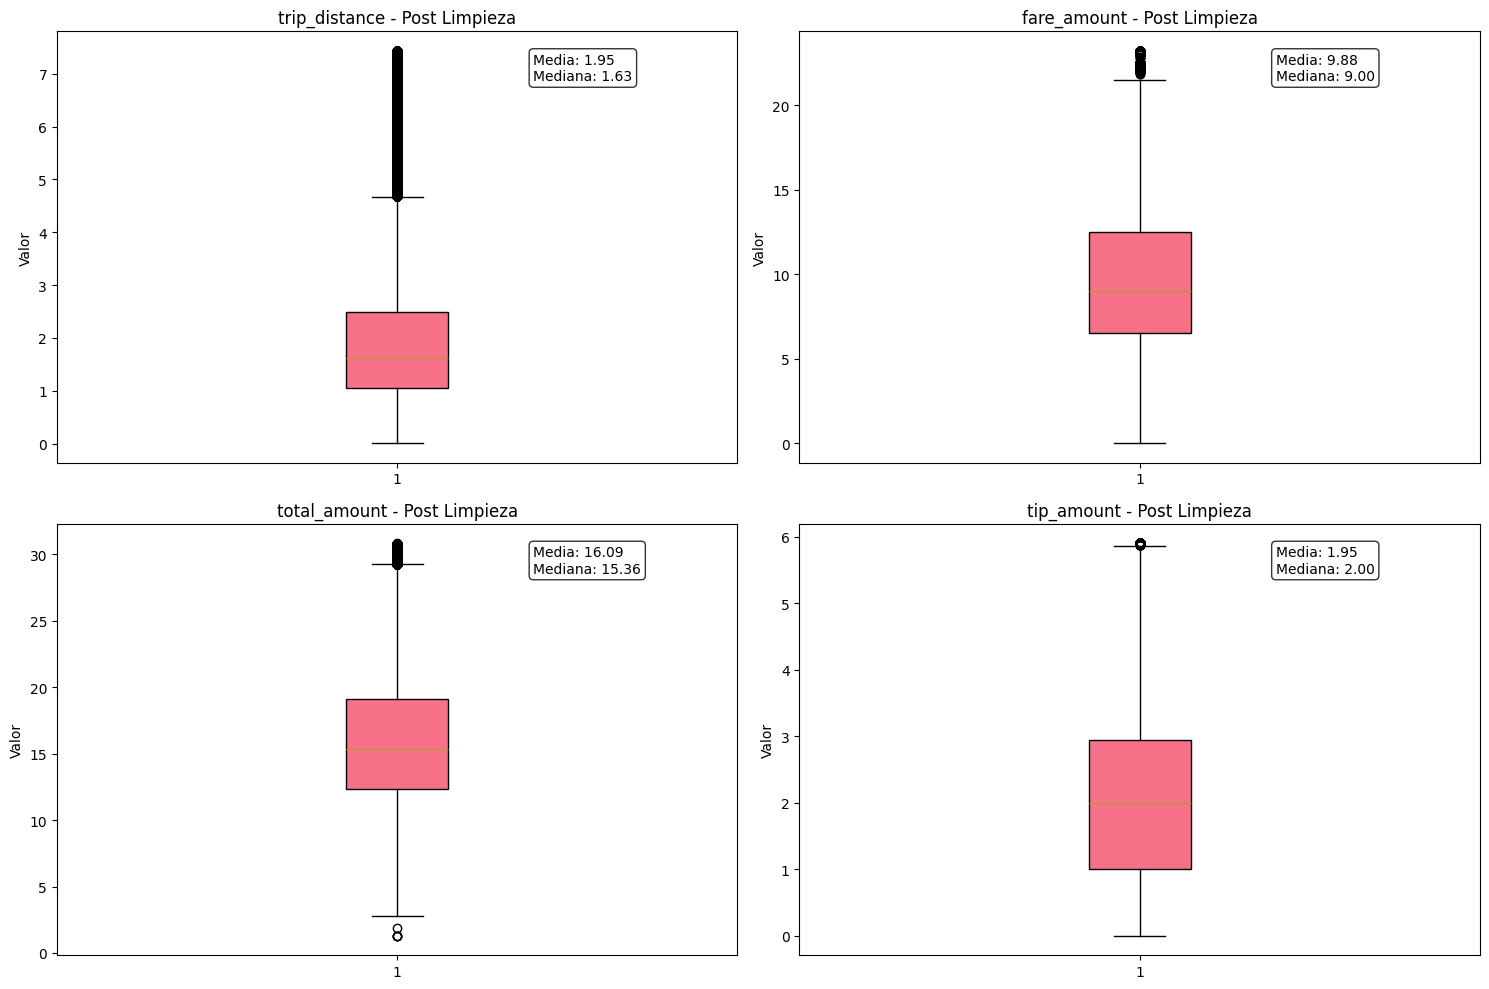


📏 RANGOS FINALES DE DATOS:
   trip_distance: Min=0.01, Q25=1.05, Q75=2.50, Max=7.43
   fare_amount: Min=0.01, Q25=6.50, Q75=12.50, Max=23.20
   total_amount: Min=1.30, Q25=12.36, Q75=19.13, Max=30.83
   fare_amount: Min=0.01, Q25=6.50, Q75=12.50, Max=23.20
   total_amount: Min=1.30, Q25=12.36, Q75=19.13, Max=30.83
   tip_amount: Min=0.00, Q25=1.00, Q75=2.95, Max=5.90
   tip_amount: Min=0.00, Q25=1.00, Q75=2.95, Max=5.90
   trip_duration_minutes: Min=1.00, Q25=6.97, Q75=15.72, Max=29.42
   trip_duration_minutes: Min=1.00, Q25=6.97, Q75=15.72, Max=29.42


In [20]:
# Ejecutar remoción de outliers
print("🎯 REMOCIÓN DE OUTLIERS")
print("="*50)

# Obtener estadísticas antes de la remoción
initial_count = len(preprocessor.df)
print(f"\n📊 Registros antes de remoción de outliers: {initial_count:,}")

# Ejecutar remoción de outliers
cleaned_outliers = preprocessor.remove_outliers(method='iqr', factor=1.5)
outlier_stats = preprocessor.preprocessing_stats['outlier_removal']

print(f"\n🧹 RESULTADOS DE REMOCIÓN DE OUTLIERS:")
print(f"   Método utilizado: {outlier_stats['method'].upper()}")
print(f"   Factor IQR: {outlier_stats['factor']}")
print(f"   Registros procesados: {outlier_stats['initial_count']:,}")
print(f"   Registros finales: {outlier_stats['final_count']:,}")
print(f"   Outliers removidos: {outlier_stats['outliers_removed']:,}")
print(f"   Porcentaje removido: {outlier_stats['removal_percentage']:.2f}%")

# Verificar la distribución después de remover outliers
if len(preprocessor.df) > 0:
    print(f"\n🔍 ESTADÍSTICAS POST-REMOCIÓN DE OUTLIERS:")
    
    # Campos analizados para outliers
    outlier_fields = ['trip_distance', 'fare_amount', 'total_amount', 'tip_amount']
    if 'trip_duration_minutes' in preprocessor.df.columns:
        outlier_fields.append('trip_duration_minutes')
    
    existing_fields = [field for field in outlier_fields if field in preprocessor.df.columns]
    
    if existing_fields:
        # Mostrar estadísticas descriptivas
        print("\n📊 Estadísticas descriptivas después de limpieza:")
        stats_df = preprocessor.df[existing_fields].describe()
        display(stats_df.round(2))
        
        # Visualización antes/después (simulación para demo)
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, field in enumerate(existing_fields[:4]):
            if i < len(axes):
                # Boxplot para mostrar la distribución limpia
                axes[i].boxplot(preprocessor.df[field], patch_artist=True)
                axes[i].set_title(f'{field} - Post Limpieza')
                axes[i].set_ylabel('Valor')
                
                # Agregar estadísticas sobre el gráfico
                mean_val = preprocessor.df[field].mean()
                median_val = preprocessor.df[field].median()
                axes[i].text(0.7, 0.95, f'Media: {mean_val:.2f}\nMediana: {median_val:.2f}', 
                           transform=axes[i].transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Ocultar subplots no utilizados
        for i in range(len(existing_fields), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar rangos finales
        print(f"\n📏 RANGOS FINALES DE DATOS:")
        for field in existing_fields:
            min_val = preprocessor.df[field].min()
            max_val = preprocessor.df[field].max()
            q25 = preprocessor.df[field].quantile(0.25)
            q75 = preprocessor.df[field].quantile(0.75)
            print(f"   {field}: Min={min_val:.2f}, Q25={q25:.2f}, Q75={q75:.2f}, Max={max_val:.2f}")
else:
    print("⚠️ No quedan datos después de la remoción de outliers!")

## 10. Resumen Final del Preprocesamiento

📋 RESUMEN COMPLETO DEL PREPROCESAMIENTO

📊 ESTADÍSTICAS GENERALES:
   Registros originales: 3,588,295
   Columnas originales: 19
   Registros finales: 2,704,171
   Columnas finales: 20
   Registros removidos: 884,124
   Porcentaje de retención: 75.36%
   Porcentaje removido: 24.64%

🔄 DETALLE POR ETAPAS:

   🕒 Limpieza Temporal:
      Registros removidos: 54,154
      Porcentaje removido: 1.51%

   🏷️ Limpieza Categórica:
      Registros removidos: 198,181
      Porcentaje removido: 5.61%

   💰 Limpieza Monetaria:
      Registros removidos: 31,024
      Porcentaje removido: 0.93%

   🧮 Validación total_amount:
      Discrepancias corregidas: 927,828
      Porcentaje de discrepancias: 28.07%

   🎯 Remoción de Outliers:
      Outliers removidos: 600,765
      Porcentaje removido: 18.18%


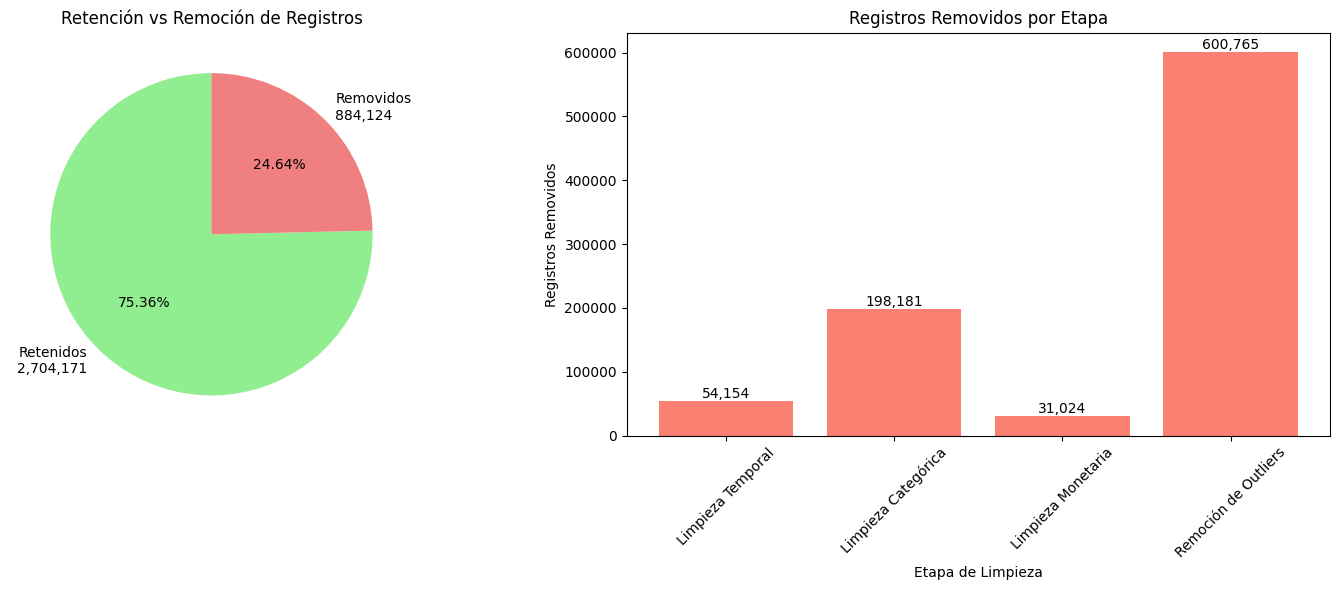


✅ PREPROCESAMIENTO COMPLETADO

📁 PRÓXIMOS PASOS:
   1. Guardar datos limpios en: d:\VSCode\nyc_taxi_project\data\processed\processed_data.parquet
   2. Proceder con ingeniería de características (features.py)
   3. Análisis exploratorio de datos limpios
   4. Modelado y evaluación


In [21]:
# Obtener resumen completo del preprocesamiento
print("📋 RESUMEN COMPLETO DEL PREPROCESAMIENTO")
print("="*60)

summary = preprocessor.get_preprocessing_summary()

if summary:
    print(f"\n📊 ESTADÍSTICAS GENERALES:")
    print(f"   Registros originales: {summary['original_shape'][0]:,}")
    print(f"   Columnas originales: {summary['original_shape'][1]}")
    
    if summary['final_shape']:
        print(f"   Registros finales: {summary['final_shape'][0]:,}")
        print(f"   Columnas finales: {summary['final_shape'][1]}")
        print(f"   Registros removidos: {summary['total_removed']:,}")
        print(f"   Porcentaje de retención: {100 - summary['removal_percentage']:.2f}%")
        print(f"   Porcentaje removido: {summary['removal_percentage']:.2f}%")
    
    print(f"\n🔄 DETALLE POR ETAPAS:")
    
    # Mostrar estadísticas de cada etapa
    stages = [
        ('datetime_cleaning', '🕒 Limpieza Temporal'),
        ('categorical_cleaning', '🏷️ Limpieza Categórica'),
        ('monetary_cleaning', '💰 Limpieza Monetaria'),
        ('total_amount_validation', '🧮 Validación total_amount'),
        ('outlier_removal', '🎯 Remoción de Outliers')
    ]
    
    for stage_key, stage_name in stages:
        if stage_key in summary['steps']:
            stage_data = summary['steps'][stage_key]
            print(f"\n   {stage_name}:")
            
            if stage_key == 'total_amount_validation':
                print(f"      Discrepancias corregidas: {stage_data['discrepancies_found']:,}")
                print(f"      Porcentaje de discrepancias: {stage_data['discrepancy_percentage']:.2f}%")
            else:
                if 'removed_records' in stage_data:
                    print(f"      Registros removidos: {stage_data['removed_records']:,}")
                    print(f"      Porcentaje removido: {stage_data['removal_percentage']:.2f}%")
                elif 'outliers_removed' in stage_data:
                    print(f"      Outliers removidos: {stage_data['outliers_removed']:,}")
                    print(f"      Porcentaje removido: {stage_data['removal_percentage']:.2f}%")
    
    # Visualización del resumen
    if summary['final_shape']:
        # Gráfico de barras mostrando retención vs remoción
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Gráfico de retención
        retained = summary['final_shape'][0]
        removed = summary['total_removed']
        
        ax1.pie([retained, removed], 
               labels=[f'Retenidos\n{retained:,}', f'Removidos\n{removed:,}'],
               colors=['lightgreen', 'lightcoral'],
               autopct='%1.2f%%',
               startangle=90)
        ax1.set_title('Retención vs Remoción de Registros')
        
        # Gráfico de etapas de limpieza
        stage_removals = []
        stage_labels = []
        
        for stage_key, stage_name in stages:
            if stage_key in summary['steps']:
                stage_data = summary['steps'][stage_key]
                if 'removed_records' in stage_data:
                    stage_removals.append(stage_data['removed_records'])
                    stage_labels.append(stage_name.split(' ', 1)[1])  # Remover emoji
                elif 'outliers_removed' in stage_data:
                    stage_removals.append(stage_data['outliers_removed'])
                    stage_labels.append(stage_name.split(' ', 1)[1])  # Remover emoji
        
        if stage_removals:
            ax2.bar(stage_labels, stage_removals, color='salmon')
            ax2.set_title('Registros Removidos por Etapa')
            ax2.set_xlabel('Etapa de Limpieza')
            ax2.set_ylabel('Registros Removidos')
            ax2.tick_params(axis='x', rotation=45)
            
            # Agregar valores sobre las barras
            for i, v in enumerate(stage_removals):
                ax2.text(i, v, f'{v:,}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

print(f"\n✅ PREPROCESAMIENTO COMPLETADO")
print(f"\n📁 PRÓXIMOS PASOS:")
print(f"   1. Guardar datos limpios en: {PROCESSED_DATA}")
print(f"   2. Proceder con ingeniería de características (features.py)")
print(f"   3. Análisis exploratorio de datos limpios")
print(f"   4. Modelado y evaluación")

## 11. Guardado de Datos Limpios

In [22]:
# Guardar los datos procesados
print("💾 GUARDANDO DATOS LIMPIOS")
print("="*50)

try:
    output_path = preprocessor.save_processed_data()
    
    print(f"\n✅ DATOS GUARDADOS EXITOSAMENTE")
    print(f"   Archivo: {output_path}")
    
    # Verificar el archivo guardado
    if Path(output_path).exists():
        file_size = Path(output_path).stat().st_size / 1024**2
        print(f"   Tamaño: {file_size:.2f} MB")
        
        # Verificar carga del archivo guardado
        test_load = pd.read_parquet(output_path)
        print(f"   Verificación de carga: ✅ {test_load.shape[0]:,} registros cargados")
        
        print(f"\n📊 RESUMEN FINAL:")
        print(f"   Dataset original: {preprocessor.original_shape[0]:,} registros")
        print(f"   Dataset limpio: {len(preprocessor.df):,} registros")
        print(f"   Retención de datos: {(len(preprocessor.df)/preprocessor.original_shape[0]*100):.2f}%")
        print(f"   Calidad de datos: ALTA (outliers removidos, valores corregidos)")
        
        del test_load  # Liberar memoria
    
except Exception as e:
    print(f"❌ ERROR AL GUARDAR DATOS: {e}")
    print(f"   Verifique permisos de escritura y espacio en disco")

print(f"\n🎯 PIPELINE DE LIMPIEZA COMPLETADO")
print(f"\n📋 DATOS LISTOS PARA:")
print(f"   ✅ Ingeniería de características (features.py)")
print(f"   ✅ Análisis exploratorio avanzado")
print(f"   ✅ Modelado de machine learning")
print(f"   ✅ Análisis de patrones temporales")
print(f"   ✅ Segmentación de clientes")

💾 GUARDANDO DATOS LIMPIOS


2025-11-28 18:17:11,427 - nyc_taxi_logger - INFO - Datos procesados guardados en: d:\VSCode\nyc_taxi_project\data\processed\processed_data.parquet
2025-11-28 18:17:11,429 - nyc_taxi_logger - INFO - Tamaño del archivo: 51.37 MB
2025-11-28 18:17:11,429 - nyc_taxi_logger - INFO - Tamaño del archivo: 51.37 MB



✅ DATOS GUARDADOS EXITOSAMENTE
   Archivo: d:\VSCode\nyc_taxi_project\data\processed\processed_data.parquet
   Tamaño: 51.37 MB
   Verificación de carga: ✅ 2,704,171 registros cargados

📊 RESUMEN FINAL:
   Dataset original: 3,588,295 registros
   Dataset limpio: 2,704,171 registros
   Retención de datos: 75.36%
   Calidad de datos: ALTA (outliers removidos, valores corregidos)

🎯 PIPELINE DE LIMPIEZA COMPLETADO

📋 DATOS LISTOS PARA:
   ✅ Ingeniería de características (features.py)
   ✅ Análisis exploratorio avanzado
   ✅ Modelado de machine learning
   ✅ Análisis de patrones temporales
   ✅ Segmentación de clientes
   Verificación de carga: ✅ 2,704,171 registros cargados

📊 RESUMEN FINAL:
   Dataset original: 3,588,295 registros
   Dataset limpio: 2,704,171 registros
   Retención de datos: 75.36%
   Calidad de datos: ALTA (outliers removidos, valores corregidos)

🎯 PIPELINE DE LIMPIEZA COMPLETADO

📋 DATOS LISTOS PARA:
   ✅ Ingeniería de características (features.py)
   ✅ Análisis expl